# Model to predict sleep state based on Actigraphy data

## Requirements
Used and proved with Python 3.11.9

In [1]:
%pip install --upgrade pip jupyterlab ipykernel
%pip install torch pandas polars transformers born matplotlib pyarrow
%pip install chronos-forecasting # Amazon's Chronos library for time series forecasting

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [2]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import time
notebook_start_time = time.time()

## A. Data acquisition
We optain the parquet with the data with:
- **ENMO**: Euclidean Norm Minus One, a measure of physical activity.
- **Anglez**: Angle of the wrist, which can indicate the position of the wrist.
- **Step**: step identifier.
- **Timestamp**: time of the measurement.

In [3]:
df = pl.read_parquet("data/train_series.parquet")

# Get the first series_id and filter data for that series only
first_series_id = df['series_id'].unique()[0]
df = df.filter(pl.col('series_id') == first_series_id)
print(f"Filtered data for series: {first_series_id}")
print(f"Data shape: {df.shape}")
print(df.head())

Filtered data for series: 04f547b8017d
Data shape: (637560, 5)
shape: (5, 5)
┌──────────────┬──────┬──────────────────────────┬────────┬──────┐
│ series_id    ┆ step ┆ timestamp                ┆ anglez ┆ enmo │
│ ---          ┆ ---  ┆ ---                      ┆ ---    ┆ ---  │
│ str          ┆ u32  ┆ str                      ┆ f32    ┆ f32  │
╞══════════════╪══════╪══════════════════════════╪════════╪══════╡
│ 04f547b8017d ┆ 0    ┆ 2018-11-28T12:00:00-0500 ┆ 0.6793 ┆ 0.0  │
│ 04f547b8017d ┆ 1    ┆ 2018-11-28T12:00:05-0500 ┆ 0.6793 ┆ 0.0  │
│ 04f547b8017d ┆ 2    ┆ 2018-11-28T12:00:10-0500 ┆ 0.6793 ┆ 0.0  │
│ 04f547b8017d ┆ 3    ┆ 2018-11-28T12:00:15-0500 ┆ 0.6793 ┆ 0.0  │
│ 04f547b8017d ┆ 4    ┆ 2018-11-28T12:00:20-0500 ┆ 0.6793 ┆ 0.0  │
└──────────────┴──────┴──────────────────────────┴────────┴──────┘


### Graphs
We plot the data to visualize the activity and angle over time.

#### ENMO

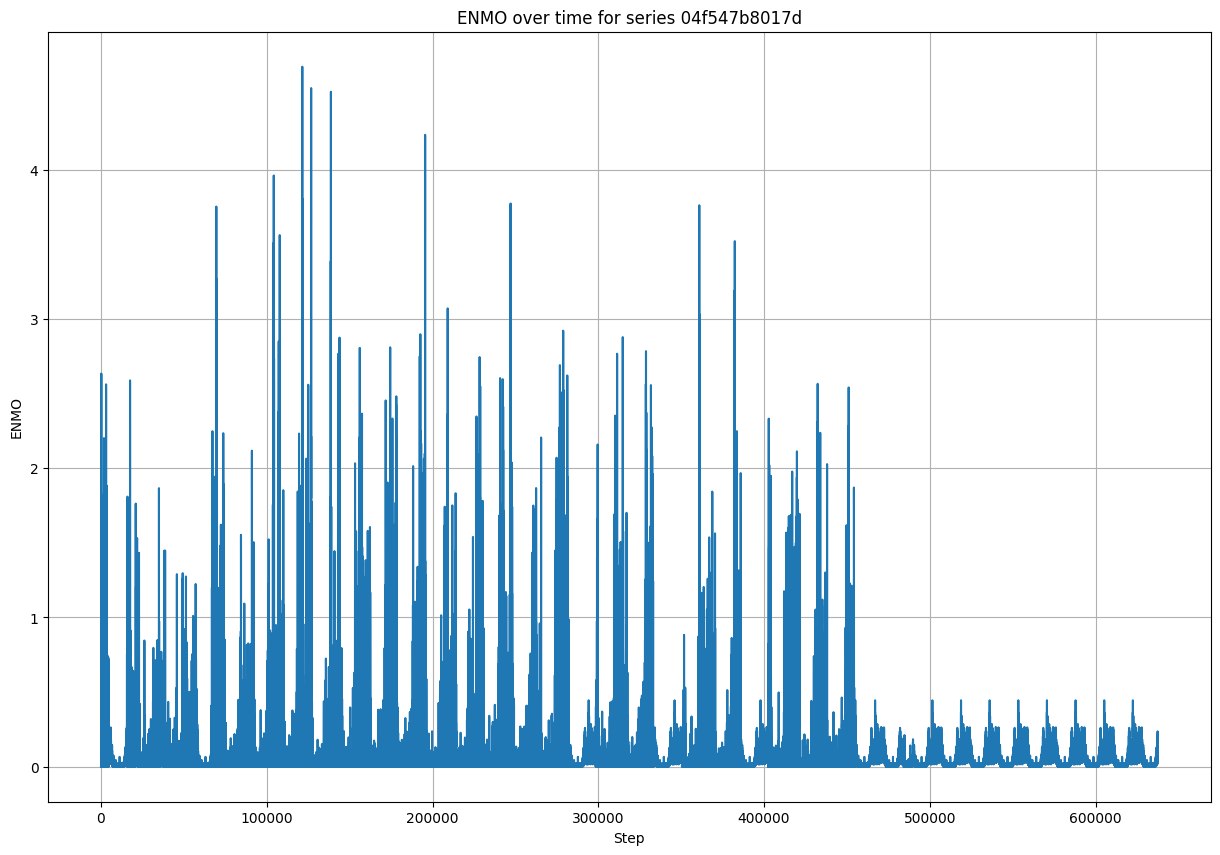

In [4]:
# Plot ENMO vs step for the first series
plt.figure(figsize=(15, 10))
plt.plot(df['step'], df['enmo'])
plt.title(f'ENMO over time for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('ENMO')
plt.grid(True)
plt.show()

#### Anglez

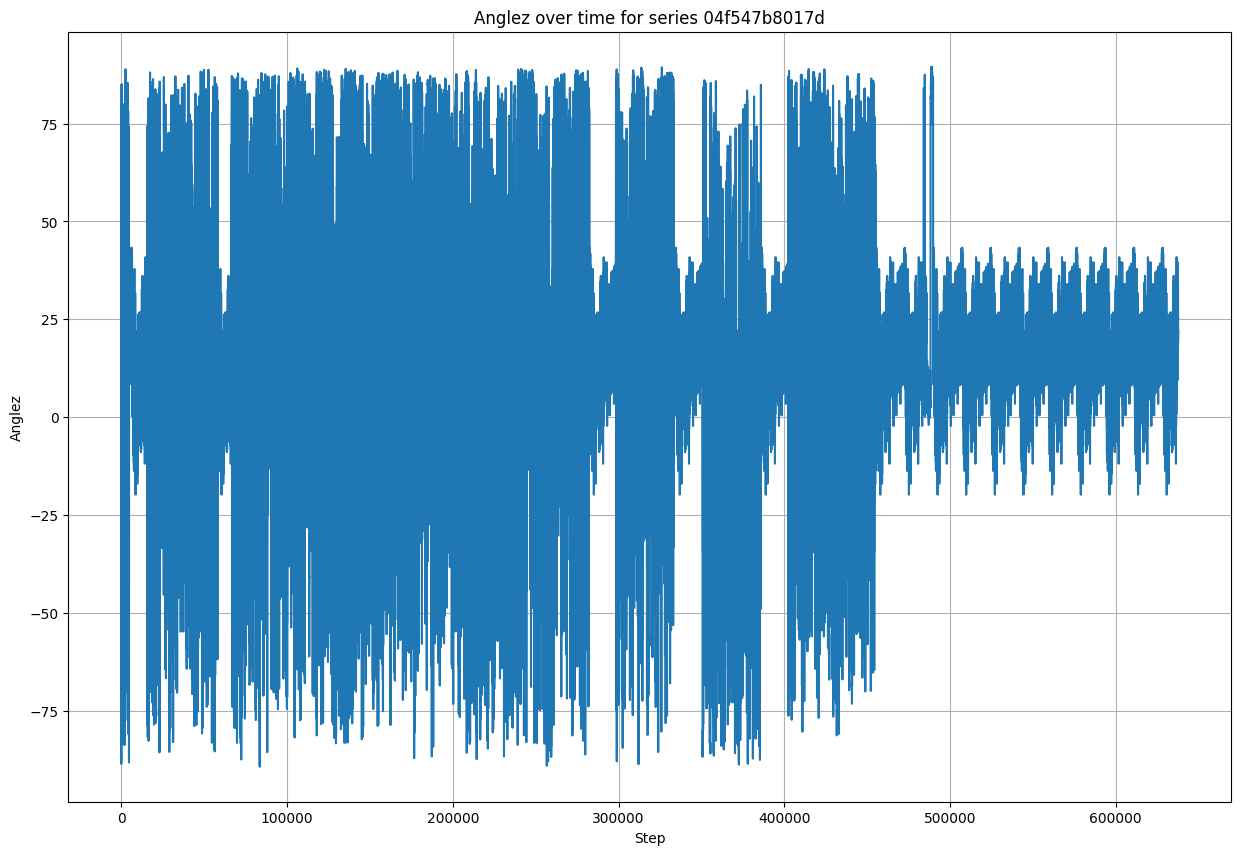

In [5]:
# Plot anglez vs step for the first series
plt.figure(figsize=(15, 10))
plt.plot(df['step'], df['anglez'])
plt.title(f'Anglez over time for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('Anglez')
plt.grid(True)
plt.show()

## B. Data processing
We obtain raw data and calibrate and filter it to prepare for modeling.
The processing includes:
- **Calibration**: Adjusting the ENMO and Anglez values to fix any biases.
- **Normalization**: Scaling the data to a standard range.
- **Gap replacement**: Filling in missing data points to ensure continuity.

### B.1 Clean and calibrate data
Adjust the ENMO and Anglez values to fix any biases. 

In [6]:
enmo_calibrated = np.clip(df['enmo'].to_numpy(), 0, None)
anglez_calibrated = df['anglez'].to_numpy()

### B.2 Normalization
Scale the data to a standard range, typically between 0 and 1, to ensure that all features contribute equally to the model.

In [7]:
# Min-Max Normalization
enmo_norm = (enmo_calibrated - enmo_calibrated.min()) / (enmo_calibrated.max() - enmo_calibrated.min())
anglez_norm = 2 * (anglez_calibrated - anglez_calibrated.min()) / (anglez_calibrated.max() - anglez_calibrated.min()) - 1

### visualization


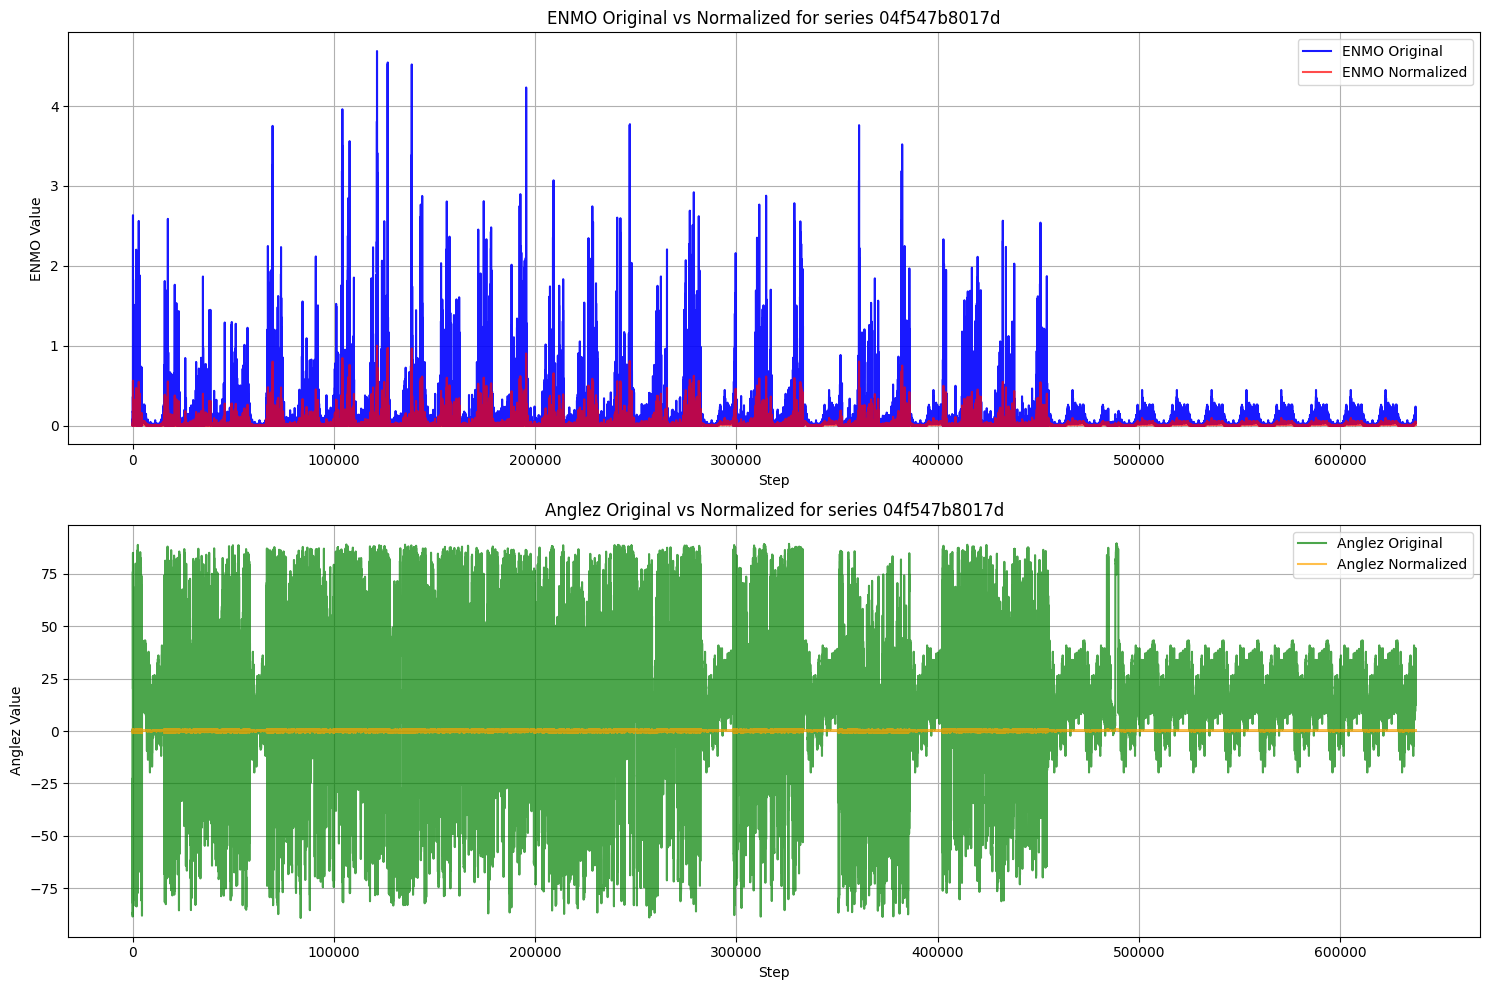

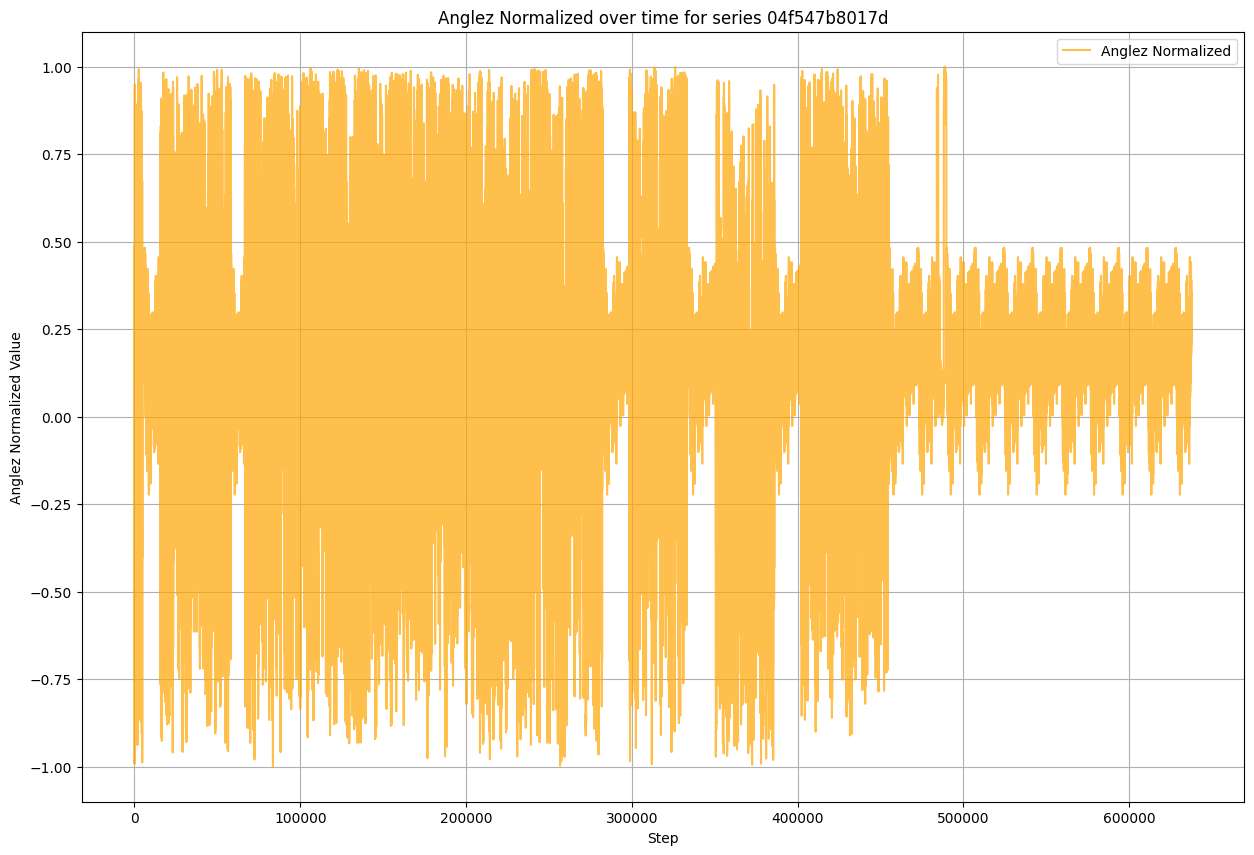

In [8]:
# Create subplots for ENMO comparison
plt.figure(figsize=(15, 10))

# ENMO comparison subplot
plt.subplot(2, 1, 1)
sns.lineplot(x=df['step'], y=df['enmo'], label='ENMO Original', color='blue', alpha=0.9)
sns.lineplot(x=df['step'], y=enmo_norm, label='ENMO Normalized', color='red', alpha=0.7)
plt.title(f'ENMO Original vs Normalized for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('ENMO Value')
plt.legend()
plt.grid(True)

# Anglez comparison subplot
plt.subplot(2, 1, 2)
sns.lineplot(x=df['step'], y=df['anglez'], label='Anglez Original', color='green', alpha=0.7)
sns.lineplot(x=df['step'], y=anglez_norm, label='Anglez Normalized', color='orange', alpha=0.7)
plt.title(f'Anglez Original vs Normalized for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('Anglez Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 10))
sns.lineplot(x=df['step'], y=anglez_norm, label='Anglez Normalized', color='orange', alpha=0.7)
plt.title(f'Anglez Normalized over time for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('Anglez Normalized Value')
plt.legend()
plt.grid(True)
plt.show()

#### Gap reduction
The dataset have been already cleaned, so we don't need to fill gaps.

In [9]:
enmo_filtered = enmo_norm
anglez_filtered = anglez_norm

## C. Feature Extraction
Extract relevant features from the processed data that can be used for modeling. 

In [10]:
# Define epoch length: 12 steps = 60 seconds (since each step represents 5 seconds)
epoch_len = 12
# A list to store the filtered data
epoch_features = []

# Iterate through the data in epochs
for i in range(0, len(enmo_filtered), epoch_len):

    # Early break, ensuring no overpass the array's length
    if i + epoch_len > len(enmo_filtered):
        break
    
    # Get the current epoch data
    enmo_epoch = enmo_filtered[i:i + epoch_len]
    anglez_epoch = anglez_filtered[i:i + epoch_len]

    # C.1 Activity count
    activity_count = np.sum(enmo_epoch) *1000  # Typical scale factor

    # C.2 Anglez mean and std (Time Pattern)
    anglez_mean = np.mean(anglez_epoch)
    anglez_std = np.std(anglez_epoch)

    epoch_features.append({
        'epoch_start_step': df['step'][i],
        'activity_count': activity_count,
        'anglez_mean': anglez_mean,
        'anglez_std': anglez_std
    })

# Convert the list of epoch features to a DataFrame
epoch_df = pd.DataFrame(epoch_features)

print(f"Number of epochs created: {epoch_df.shape[0]}")
print("First 5 epochs with their features:")
print(epoch_df.head())

# --- C.2 Feature Sorter ---
# Classify and organize the data for the next step (Classification)
print(f"\nFeature extraction completed.")
print(f"Extracted features: {list(epoch_df.columns)}")
print(f"Data shape ready for classification: {epoch_df.shape}")
print(f"Activity count range: [{epoch_df['activity_count'].min():.2f}, {epoch_df['activity_count'].max():.2f}]")
print(f"Anglez stability range: [{epoch_df['anglez_std'].min():.2f}, {epoch_df['anglez_std'].max():.2f}]")

Number of epochs created: 53130
First 5 epochs with their features:
   epoch_start_step  activity_count  anglez_mean  anglez_std
0                 0        0.000000     0.006176    0.000000
1                12       26.289979    -0.279189    0.421430
2                24       10.149254    -0.974325    0.007367
3                36       39.339021    -0.969643    0.011552
4                48        9.360341    -0.960492    0.004847

Feature extraction completed.
Extracted features: ['epoch_start_step', 'activity_count', 'anglez_mean', 'anglez_std']
Data shape ready for classification: (53130, 4)
Activity count range: [0.00, 5538.95]
Anglez stability range: [0.00, 0.79]


## D. Classification
Classify sleep/wake states using established actigraphy algorithms.


### D.1 Sleep State Detector

In [11]:
def sadeh_algorithm(activity_counts):
    """
    Sadeh Algorithm (1994) for sleep/wake classification
    Reference: Sadeh, A., Sharkey, K. M., & Carskadon, M. A. (1994). 
    Activity-based sleep-wake identification: an empirical test of methodological issues.
    
    Formula: PS = 7.601 - 0.065*Mean5 - 1.08*Nat - 0.0056*SD - 0.073*Lg10
    Where PS > 0 indicates SLEEP, PS <= 0 indicates WAKE
    """
    sleep_scores = []
    
    for i in range(len(activity_counts)):
        # Get current epoch and surrounding epochs (window of 5: i-2, i-1, i, i+1, i+2)
        window_start = max(0, i-2)
        window_end = min(len(activity_counts), i+3)
        window_values = activity_counts[window_start:window_end]
        
        # Mean of 5 epochs centered on current epoch
        mean_5 = np.mean(window_values)
        
        # Natural log of current epoch activity (+1 to avoid log(0))
        nat_log = np.log(activity_counts[i] + 1)
        
        # Standard deviation of the 5-epoch window
        std_dev = np.std(window_values)
        
        # Log10 of current epoch activity (+1 to avoid log(0))
        log10_activity = np.log10(activity_counts[i] + 1)
        
        # Sadeh formula
        sadeh_score = 7.601 - 0.065*mean_5 - 1.08*nat_log - 0.0056*std_dev - 0.073*log10_activity
        
        # Sleep if score > 0, Wake if score <= 0
        sleep_scores.append(1 if sadeh_score > 0 else 0)
    
    return np.array(sleep_scores)

def cole_kripke_algorithm(activity_counts):
    """
    Cole-Kripke Algorithm (1992) for sleep/wake classification
    Reference: Cole, R. J., Kripke, D. F., Gruen, W., Mullaney, D. J., & Gillin, J. C. (1992).
    Automatic sleep/wake identification from wrist activity.
    
    Formula: D = P(W) = A-4*0.00001 + A-3*0.0001 + A-2*0.0005 + A-1*0.003 + A0*0.006 + A+1*0.003 + A+2*0.0005
    Where D < 1 indicates SLEEP, D >= 1 indicates WAKE
    """
    sleep_scores = []
    
    for i in range(len(activity_counts)):
        # Get surrounding epochs with boundary handling (using 0 for out-of-bounds)
        a_minus_4 = activity_counts[i-4] if i >= 4 else 0
        a_minus_3 = activity_counts[i-3] if i >= 3 else 0
        a_minus_2 = activity_counts[i-2] if i >= 2 else 0
        a_minus_1 = activity_counts[i-1] if i >= 1 else 0
        a_0 = activity_counts[i]  # current epoch
        a_plus_1 = activity_counts[i+1] if i < len(activity_counts)-1 else 0
        a_plus_2 = activity_counts[i+2] if i < len(activity_counts)-2 else 0
        
        # Cole-Kripke weighted formula (original coefficients)
        d_score = (a_minus_4 * 0.00001 + 
                   a_minus_3 * 0.0001 + 
                   a_minus_2 * 0.0005 + 
                   a_minus_1 * 0.003 + 
                   a_0 * 0.006 + 
                   a_plus_1 * 0.003 + 
                   a_plus_2 * 0.0005)
        
        # Sleep if D < 1, Wake if D >= 1
        sleep_scores.append(1 if d_score < 1.0 else 0)
    
    return np.array(sleep_scores)

def opal_algorithm(activity_counts, anglez_std):
    """
    OPAL Algorithm for sleep/wake classification using activity and posture stability.
    This implementation focuses on low activity + high stability = sleep.
    
    The logic is: High activity clearly indicates wake state, while low activity 
    combined with postural stability (low angle variance) indicates sleep.
    """
    activity_counts = np.array(activity_counts)
    anglez_std = np.array(anglez_std)
    
    # 1. Activity threshold - high activity always means wake
    # Using percentile-based thresholds to adapt to different activity scales
    high_activity_threshold = np.percentile(activity_counts, 75)
    low_activity_threshold = np.percentile(activity_counts, 25)
    
    # 2. Stability threshold - low std means high stability (good for sleep)
    stability_threshold = np.percentile(anglez_std, 50)  # median
    
    sleep_scores = []
    
    for i in range(len(activity_counts)):
        activity = activity_counts[i]
        stability = anglez_std[i]
        
        # Rule-based classification:
        if activity > high_activity_threshold:
            # High activity = definitely wake
            sleep_score = 0
        elif activity < low_activity_threshold and stability < stability_threshold:
            # Low activity + high stability = likely sleep
            sleep_score = 1
        else:
            # Intermediate case: use weighted combination
            # Normalize features to [0,1] range
            activity_norm = min(1.0, activity / high_activity_threshold)
            stability_norm = min(1.0, stability / (2 * stability_threshold))  # inverted: low std = high stability
            
            # Combined score: sleep more likely with low activity and low angle variance
            sleep_probability = (1 - activity_norm) * 0.7 + (1 - stability_norm) * 0.3
            sleep_score = 1 if sleep_probability > 0.5 else 0
        
        sleep_scores.append(sleep_score)
    
    return np.array(sleep_scores)


In [12]:
# Apply all three algorithms to your epoch data
print("Applying sleep classification algorithms...")

# Extract activity counts and anglez std for algorithms
activity_counts = epoch_df['activity_count'].values
anglez_std_values = epoch_df['anglez_std'].values

# Apply algorithms
sadeh_results = sadeh_algorithm(activity_counts)
cole_kripke_results = cole_kripke_algorithm(activity_counts)
opal_results = opal_algorithm(activity_counts, anglez_std_values)

Applying sleep classification algorithms...


In [13]:
# Add results to DataFrame
epoch_df['sadeh_sleep'] = sadeh_results
epoch_df['cole_kripke_sleep'] = cole_kripke_results  
epoch_df['opal_sleep'] = opal_results

print(f"Classification completed for {len(epoch_df)} epochs:")
print(f"Sadeh - Sleep epochs: {np.sum(sadeh_results)}/{len(sadeh_results)} ({np.mean(sadeh_results)*100:.1f}%)")
print(f"Cole-Kripke - Sleep epochs: {np.sum(cole_kripke_results)}/{len(cole_kripke_results)} ({np.mean(cole_kripke_results)*100:.1f}%)")
print(f"Opal - Sleep epochs: {np.sum(opal_results)}/{len(opal_results)} ({np.mean(opal_results)*100:.1f}%)")

print("\nFirst 10 epochs with classifications:")
print(epoch_df[['epoch_start_step', 'activity_count', 'anglez_std', 'sadeh_sleep', 'cole_kripke_sleep', 'opal_sleep']].head(200))

Classification completed for 53130 epochs:
Sadeh - Sleep epochs: 27833/53130 (52.4%)
Cole-Kripke - Sleep epochs: 31353/53130 (59.0%)
Opal - Sleep epochs: 29204/53130 (55.0%)

First 10 epochs with classifications:
     epoch_start_step  activity_count  anglez_std  sadeh_sleep  \
0                   0        0.000000    0.000000            1   
1                  12       26.289979    0.421430            1   
2                  24       10.149254    0.007367            1   
3                  36       39.339021    0.011552            1   
4                  48        9.360341    0.004847            1   
..                ...             ...         ...          ...   
195              2340      619.722784    0.290265            0   
196              2352       99.658847    0.106621            0   
197              2364      200.788900    0.445077            0   
198              2376      136.140719    0.087518            0   
199              2388       65.948822    0.257818            

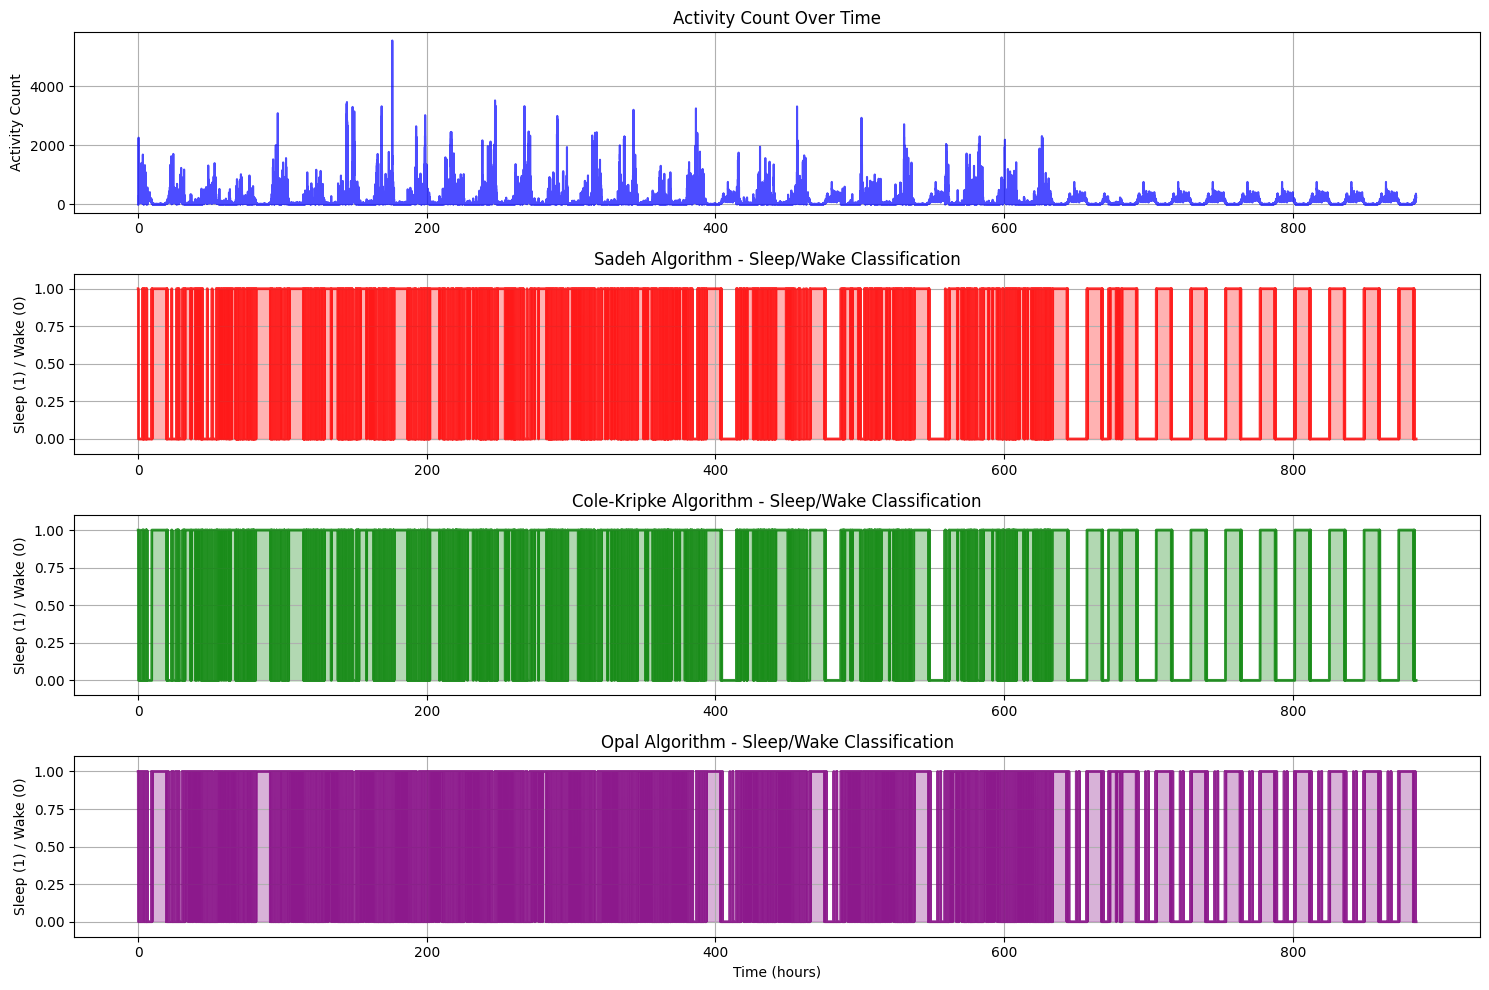

In [14]:
# Visualize the sleep/wake classifications
plt.figure(figsize=(15, 10))

# Create time axis (convert epoch steps to hours for better readability)

time_hours = epoch_df['epoch_start_step'].to_numpy()/(12*60) # minutes


# Plot 1: Activity Count over time
plt.subplot(4, 1, 1)
plt.plot(time_hours, epoch_df['activity_count'], alpha=0.7, color='blue')
plt.title('Activity Count Over Time')
plt.ylabel('Activity Count')
plt.grid(True)

# Plot 2: Sadeh Classification
plt.subplot(4, 1, 2)
plt.plot(time_hours, epoch_df['sadeh_sleep'], alpha=0.8, color='red', linewidth=2)
plt.fill_between(time_hours, 0, epoch_df['sadeh_sleep'], alpha=0.3, color='red')
plt.title('Sadeh Algorithm - Sleep/Wake Classification')
plt.ylabel('Sleep (1) / Wake (0)')
plt.ylim(-0.1, 1.1)
plt.grid(True)

# Plot 3: Cole-Kripke Classification  
plt.subplot(4, 1, 3)
plt.plot(time_hours, epoch_df['cole_kripke_sleep'], alpha=0.8, color='green', linewidth=2)
plt.fill_between(time_hours, 0, epoch_df['cole_kripke_sleep'], alpha=0.3, color='green')
plt.title('Cole-Kripke Algorithm - Sleep/Wake Classification')
plt.ylabel('Sleep (1) / Wake (0)')
plt.ylim(-0.1, 1.1)
plt.grid(True)

# Plot 4: Opal Classification
plt.subplot(4, 1, 4)
plt.plot(time_hours, epoch_df['opal_sleep'], alpha=0.8, color='purple', linewidth=2)
plt.fill_between(time_hours, 0, epoch_df['opal_sleep'], alpha=0.3, color='purple')
plt.title('Opal Algorithm - Sleep/Wake Classification')
plt.ylabel('Sleep (1) / Wake (0)')
plt.xlabel('Time (hours)')
plt.ylim(-0.1, 1.1)
plt.grid(True)

plt.tight_layout()
plt.show()

### D.2 Sleep Data Sequencer

Now we have to iterate over the data to find the longest sleep period, at least 30 minutes, and extract it.

In [15]:
epoch_df

,epoch_start_step,activity_count,anglez_mean,anglez_std,sadeh_sleep,cole_kripke_sleep,opal_sleep
0,0,0.000000,0.006176,0.000000,1,1,1
1,12,26.289979,-0.279189,0.421430,1,1,1
2,24,10.149254,-0.974325,0.007367,1,1,1
3,36,39.339021,-0.969643,0.011552,1,1,1
4,48,9.360341,-0.960492,0.004847,1,1,1
...,...,...,...,...,...,...,...
53125,637500,213.560760,0.347741,0.031749,0,0,0
53126,637512,216.012791,0.348271,0.034034,0,0,0
53127,637524,249.701500,0.322031,0.030880,0,0,0
53128,637536,214.434981,0.337543,0.020750,0,0,0


## E. Sleep State Prediction
Use the extracted features to predict sleep states using a LLM (Amazon's Chronos model).


### E.1 Importing Model chronos-forecasting

In [16]:
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-tiny",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

### E.2 Algorithms Data Adquisition

The data from every algorithm is divided by 180 in order to get 15 minutes intervals to, which 10 minutes are used to train the model and 5 minutes
to predice and comparate to analyze the model precision 

In [17]:
sadeh_data = epoch_df['sadeh_sleep']
cole_kripke_sleep_data = epoch_df['cole_kripke_sleep']
opal_sleep_data = epoch_df['opal_sleep']

In [18]:
def predict_sleep_states(pipeline, data, container, name):

    chunks = np.array_split(data, len(data) // 180)
    lows = torch.empty((0), dtype=torch.bfloat16)
    medians = torch.empty((0), dtype=torch.bfloat16)
    highs = torch.empty((0), dtype=torch.bfloat16)
    real_data = np.array([])

    for data in chunks:
        data_predict = data[:120]
        data_test = data[120:]
        real_data = np.concatenate((real_data, data_test.to_numpy()), axis=0) # type: ignore
        quantiles, mean = pipeline.predict_quantiles(
            context=torch.tensor(data_predict.to_numpy()), # type: ignore
            prediction_length=60,
            quantile_levels=[0.1, 0.5, 0.9],
        )
        low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]
        lows = torch.cat((lows, low), dim=0)
        medians = torch.cat((medians, median), dim=0)
        highs = torch.cat((highs, high), dim=0)
        container[name] = lows, medians, highs, real_data
        


The model runs for every algorithm data in multithreading process to maximize resources

In [19]:
import threading

results = {'Sadeh': None, 'Cole_kripke': None, 'Opal': None}
saddeh_thread = threading.Thread(target=predict_sleep_states, args=(pipeline, sadeh_data, results, 'Sadeh'))
cole_kripke_thread = threading.Thread(target=predict_sleep_states, args=(pipeline, cole_kripke_sleep_data, results, 'Cole_kripke'))
opal_thread = threading.Thread(target=predict_sleep_states, args=(pipeline, opal_sleep_data, results, 'Opal'))

saddeh_thread.start()
cole_kripke_thread.start()
opal_thread.start()
saddeh_thread.join()
cole_kripke_thread.join()
opal_thread.join()

c:\Users\Usuario\Documents\SleepStatesPrediction\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


### E.3 Results

The following graphics shows the similarity between predicted data and real data, within threshold from the model and the middle the most accurate prediction, the prediction median

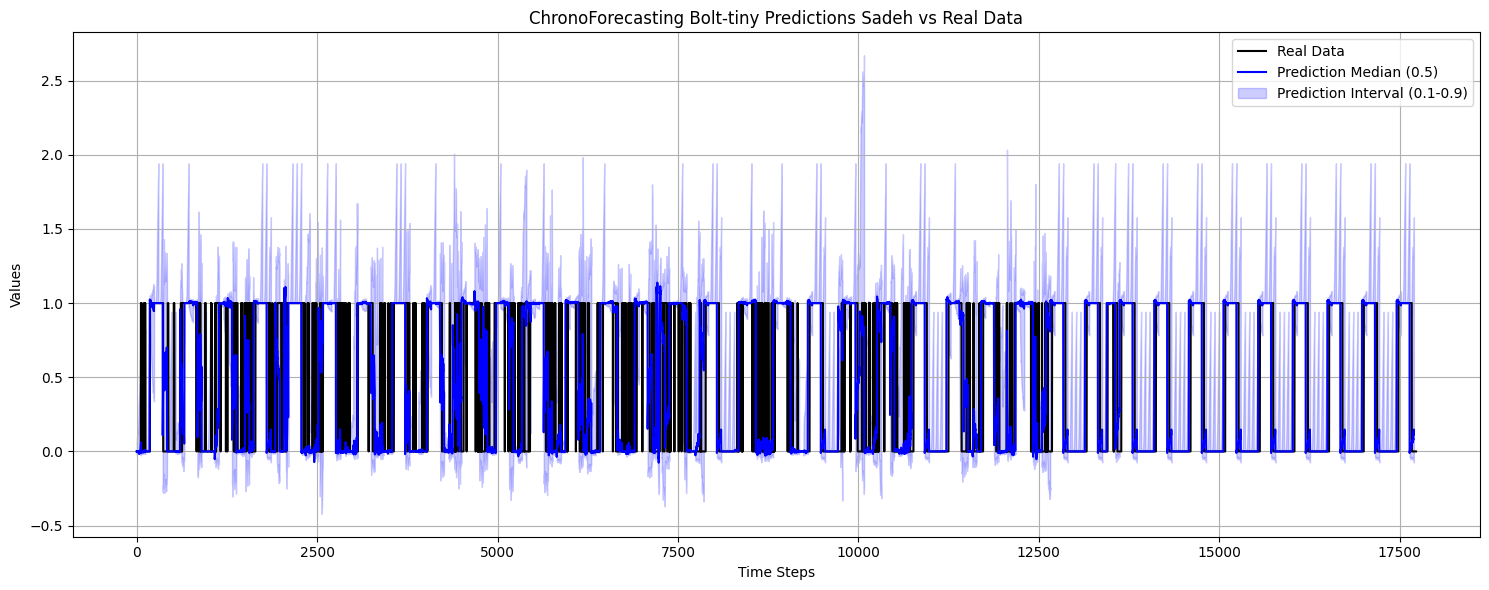

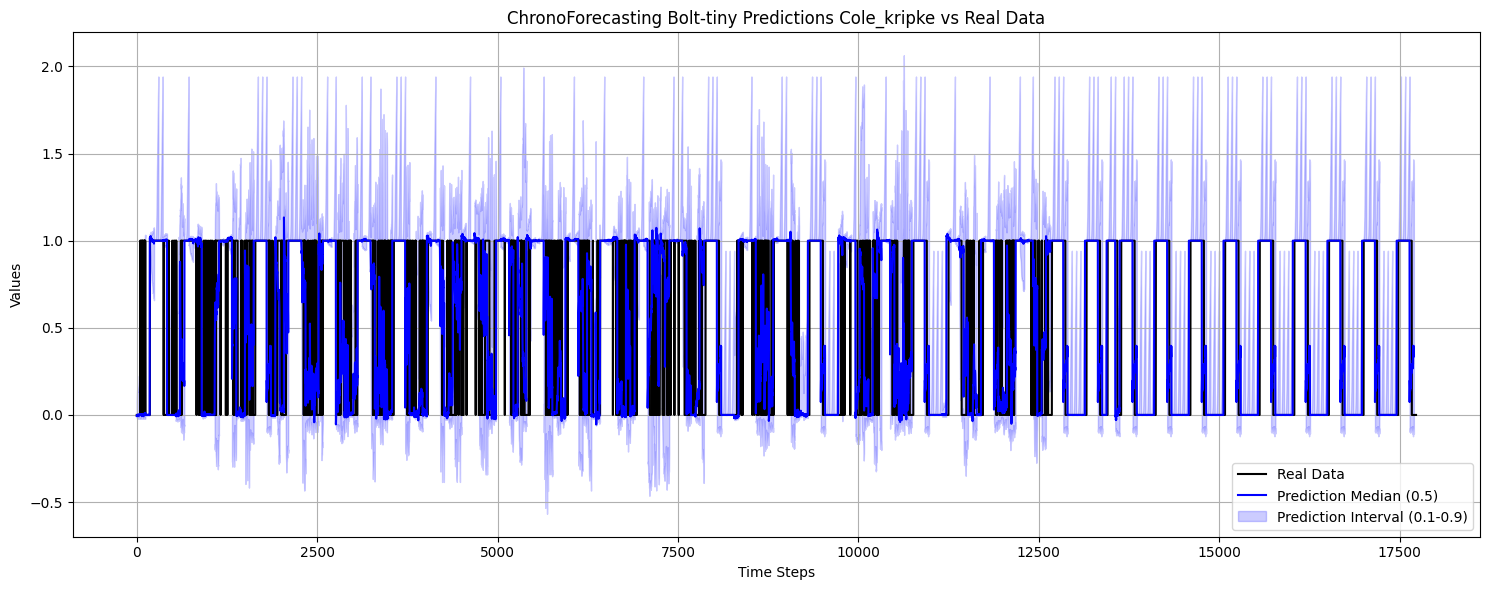

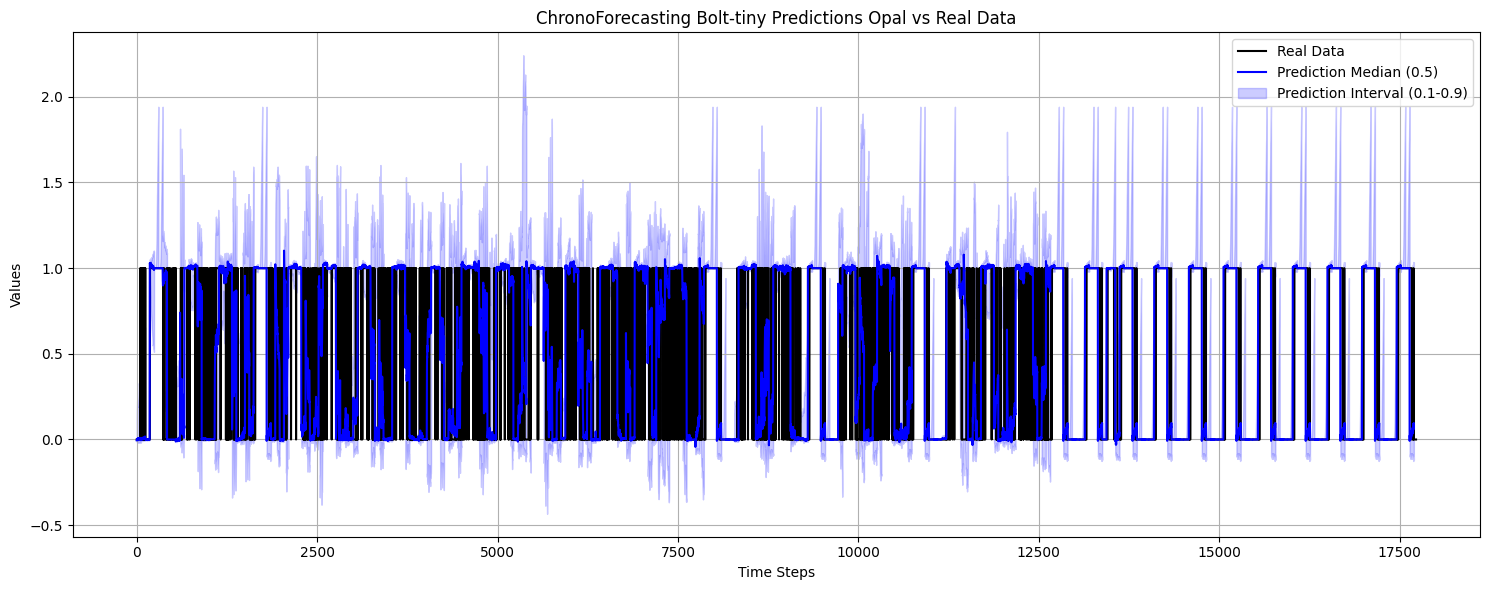

In [20]:
for name in ['Sadeh', 'Cole_kripke', 'Opal']:

    lows, medians, highs, real_data = results[name] # type: ignore
    plt.figure(figsize=(15, 6))
    plt.plot(real_data, label='Real Data', color='black')
    plt.plot(medians, label='Prediction Median (0.5)', color='blue')
    plt.fill_between(np.arange(len(medians)), lows, highs, color='blue', alpha=0.2, label='Prediction Interval (0.1-0.9)')
    plt.title(f'ChronoForecasting Bolt-tiny Predictions {name} vs Real Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def calculate_metrics(predictions, real_data):
    """Calculate classification metrics"""
    # Convert predictions to binary (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)
    binary_real = real_data.astype(int)
    
    accuracy = accuracy_score(binary_real, binary_predictions)
    precision = precision_score(binary_real, binary_predictions, zero_division=0)
    recall = recall_score(binary_real, binary_predictions, zero_division=0)
    f1 = f1_score(binary_real, binary_predictions, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Extract predictions and real data for each algorithm
algorithms_comparison = {}

for name in ['Sadeh', 'Cole_kripke', 'Opal']:
    lows, medians, highs, real_data = results[name] # type: ignore
    
    # Convert to numpy arrays
    predictions = medians.cpu().numpy()
    real_values = real_data
    
    # Ensure both arrays have the same length by taking the minimum
    min_length = min(len(predictions), len(real_values))
    predictions = predictions[:min_length]
    real_values = real_values[:min_length]
    
    print(f"{name}: predictions length = {len(predictions)}, real_data length = {len(real_values)}")
    
    # Calculate metrics
    metrics = calculate_metrics(predictions, real_values)
    
    algorithms_comparison[name] = {
        'predictions': predictions,
        'real_data': real_values,
        'metrics': metrics
    }

# Display comparison results
print("=== COMPARATIVE ANALYSIS: LLM PREDICTIONS vs REAL DATA ===\n")

for alg_name, data in algorithms_comparison.items():
    metrics = data['metrics']
    print(f"{alg_name.upper()} Algorithm:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1_score']:.4f}")
    print()

# Find the best performing algorithm
best_algorithm = max(algorithms_comparison.keys(), 
                    key=lambda x: algorithms_comparison[x]['metrics']['f1_score'])

print(f"🏆 BEST ALGORITHM: {best_algorithm.upper()}")
print(f"   F1-Score: {algorithms_comparison[best_algorithm]['metrics']['f1_score']:.4f}")

Sadeh: predictions length = 17700, real_data length = 17700
Cole_kripke: predictions length = 17700, real_data length = 17700
Opal: predictions length = 17700, real_data length = 17700
=== COMPARATIVE ANALYSIS: LLM PREDICTIONS vs REAL DATA ===

SADEH Algorithm:
  Accuracy:  0.8015
  Precision: 0.8123
  Recall:    0.7751
  F1-Score:  0.7933

COLE_KRIPKE Algorithm:
  Accuracy:  0.7961
  Precision: 0.8290
  Recall:    0.7899
  F1-Score:  0.8090

OPAL Algorithm:
  Accuracy:  0.7923
  Precision: 0.8101
  Recall:    0.7751
  F1-Score:  0.7922

🏆 BEST ALGORITHM: COLE_KRIPKE
   F1-Score: 0.8090


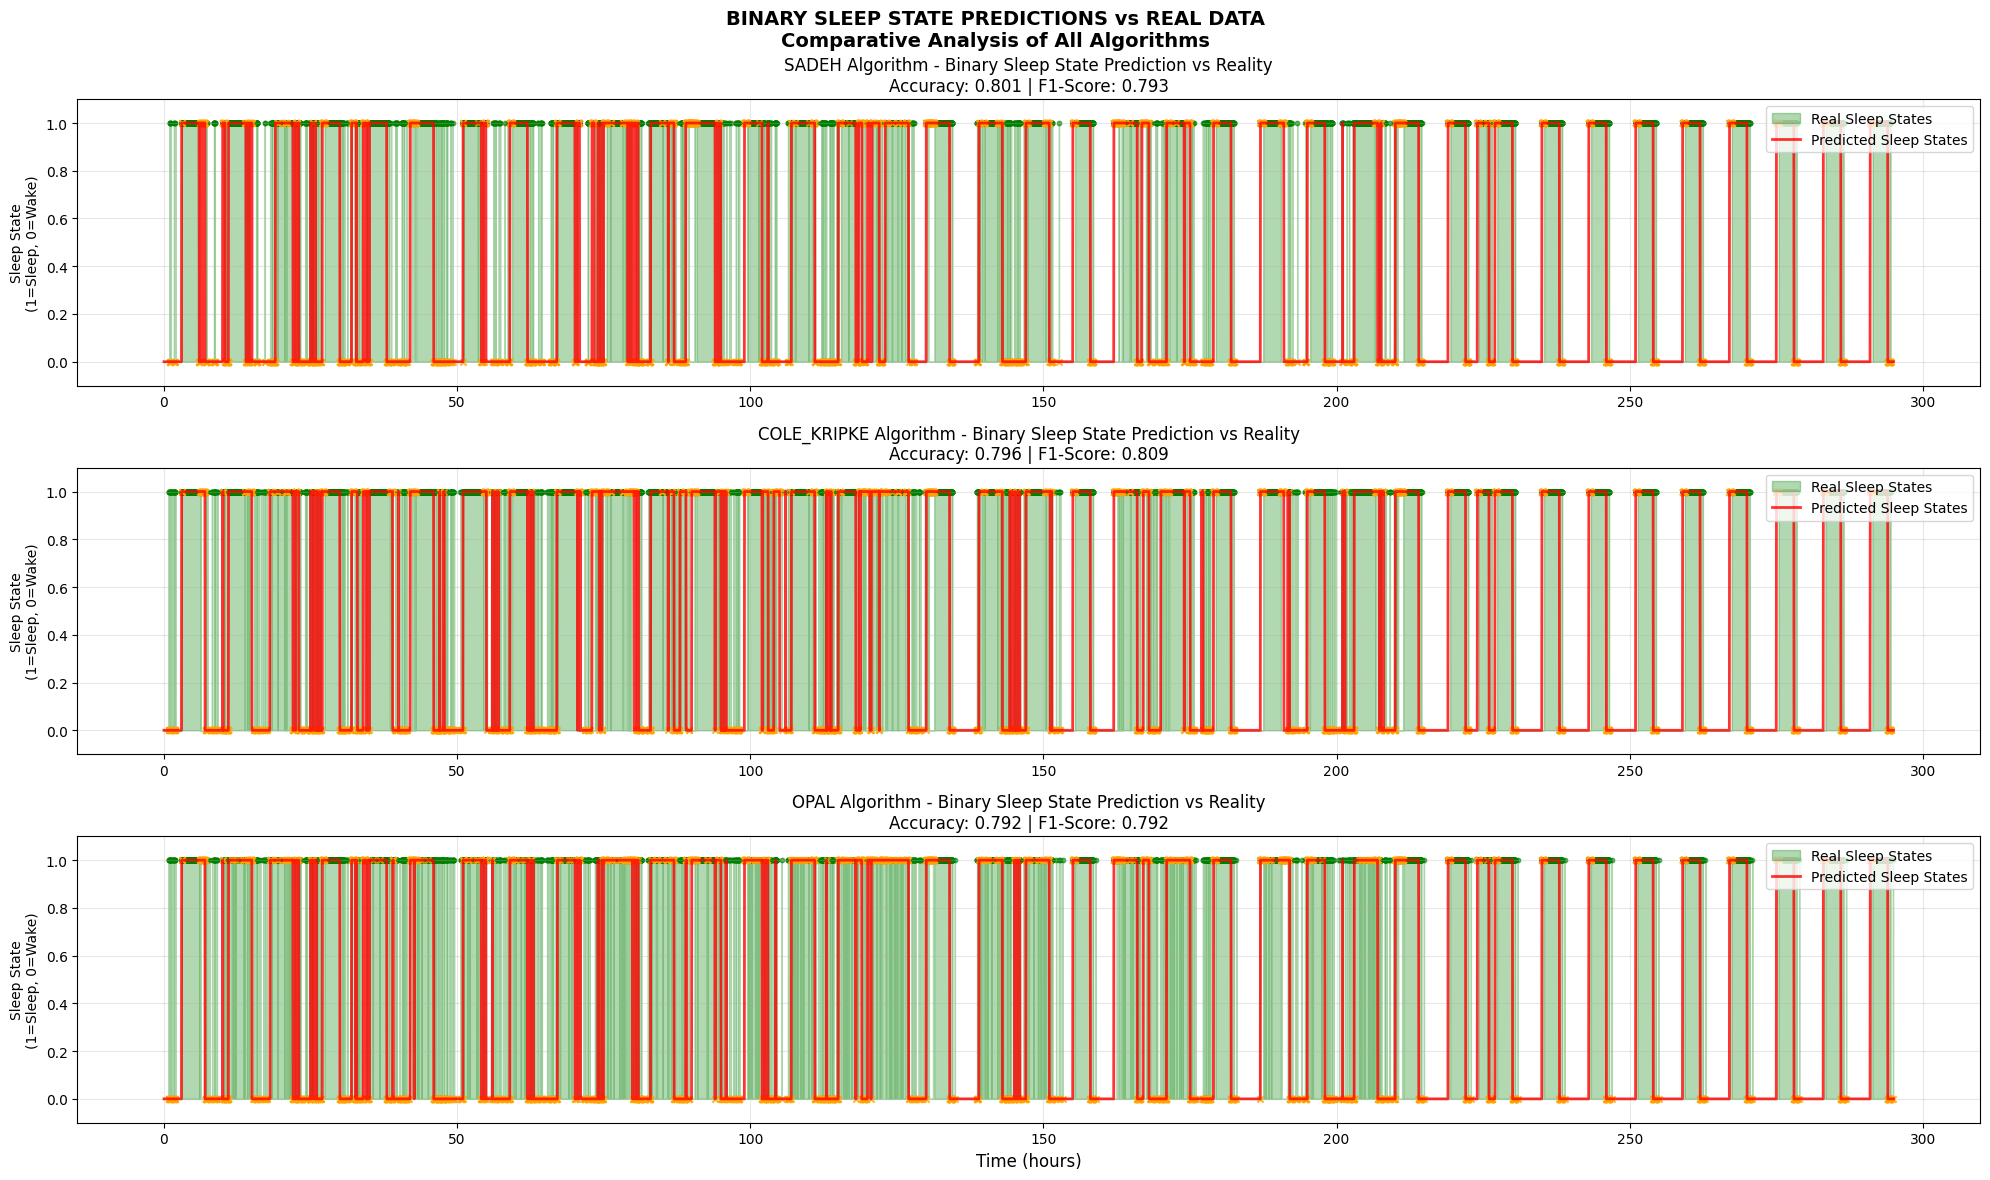

BINARY CLASSIFICATION PERFORMANCE SUMMARY
Algorithm    Accuracy   Precision  Recall     F1-Score   Mismatches  
--------------------------------------------------------------------------------
SADEH        0.801      0.812      0.775      0.793      3514        
COLE_KRIPKE  0.796      0.829      0.790      0.809      3609        
OPAL         0.792      0.810      0.775      0.792      3676        


In [22]:
# Create a comprehensive binary comparison visualization
plt.figure(figsize=(20, 12))

# Create time axis for better readability (convert to hours)
time_hours = np.arange(len(algorithms_comparison['Sadeh']['real_data'])) / 60  # Convert to hours

for i, (alg_name, data) in enumerate(algorithms_comparison.items()):
    binary_predictions = (data['predictions'] > 0.5).astype(int)
    binary_real = data['real_data'].astype(int)
    
    # Create subplot for each algorithm
    plt.subplot(3, 1, i+1)
    
    # Plot real data as filled area
    plt.fill_between(time_hours, 0, binary_real, alpha=0.3, color='green', 
                     label='Real Sleep States', step='pre')
    
    # Plot predictions as line
    plt.plot(time_hours, binary_predictions, color='red', linewidth=2, 
             label='Predicted Sleep States', alpha=0.8)
    
    # Add markers for better visibility
    sleep_pred_indices = np.where(binary_predictions == 1)[0]
    sleep_real_indices = np.where(binary_real == 1)[0]
    
    plt.scatter(time_hours[sleep_pred_indices], binary_predictions[sleep_pred_indices], 
               color='blue', s=10, alpha=0.6)
    plt.scatter(time_hours[sleep_real_indices], binary_real[sleep_real_indices], 
               color='green', s=10, alpha=0.6)
    
    # Formatting
    plt.title(f'{alg_name.upper()} Algorithm - Binary Sleep State Prediction vs Reality\n'
              f'Accuracy: {data["metrics"]["accuracy"]:.3f} | '
              f'F1-Score: {data["metrics"]["f1_score"]:.3f}', fontsize=12)
    plt.ylabel('Sleep State\n(1=Sleep, 0=Wake)', fontsize=10)
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    
    # Add difference highlighting
    differences = binary_predictions != binary_real
    if np.any(differences):
        diff_indices = np.where(differences)[0]
        plt.scatter(time_hours[diff_indices], binary_predictions[diff_indices], 
                   color='orange', s=20, marker='x', alpha=0.8, 
                   label=f'Mismatches ({np.sum(differences)} points)')

plt.xlabel('Time (hours)', fontsize=12)
plt.suptitle('BINARY SLEEP STATE PREDICTIONS vs REAL DATA\nComparative Analysis of All Algorithms', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Create a summary statistics table
print("="*80)
print("BINARY CLASSIFICATION PERFORMANCE SUMMARY")
print("="*80)
print(f"{'Algorithm':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Mismatches':<12}")
print("-"*80)

for alg_name, data in algorithms_comparison.items():
    binary_predictions = (data['predictions'] > 0.5).astype(int)
    binary_real = data['real_data'].astype(int)
    mismatches = np.sum(binary_predictions != binary_real)
    
    print(f"{alg_name.upper():<12} "
          f"{data['metrics']['accuracy']:<10.3f} "
          f"{data['metrics']['precision']:<10.3f} "
          f"{data['metrics']['recall']:<10.3f} "
          f"{data['metrics']['f1_score']:<10.3f} "
          f"{mismatches:<12}")

print("="*80)

### E.4 Evaluation
The model is evaluated based on the accuracy of its predictions compared to the actual sleep states.

In [23]:
# Load file train_events.csv
test_df = pl.read_csv("data/train_events.csv")

In [24]:
test_df

series_id,night,event,step,timestamp
str,i64,str,i64,str
"""038441c925bb""",1,"""onset""",4992,"""2018-08-14T22:26:00-0400"""
"""038441c925bb""",1,"""wakeup""",10932,"""2018-08-15T06:41:00-0400"""
"""038441c925bb""",2,"""onset""",20244,"""2018-08-15T19:37:00-0400"""
"""038441c925bb""",2,"""wakeup""",27492,"""2018-08-16T05:41:00-0400"""
"""038441c925bb""",3,"""onset""",39996,"""2018-08-16T23:03:00-0400"""
…,…,…,…,…
"""fe90110788d2""",33,"""wakeup""",560604,"""2017-09-06T04:07:00-0400"""
"""fe90110788d2""",34,"""onset""",574620,"""2017-09-06T23:35:00-0400"""
"""fe90110788d2""",34,"""wakeup""",581604,"""2017-09-07T09:17:00-0400"""


Test series data for 04f547b8017d:
Shape: (74, 5)
shape: (5, 5)
┌──────────────┬───────┬────────┬───────┬──────────────────────────┐
│ series_id    ┆ night ┆ event  ┆ step  ┆ timestamp                │
│ ---          ┆ ---   ┆ ---    ┆ ---   ┆ ---                      │
│ str          ┆ i64   ┆ str    ┆ i64   ┆ str                      │
╞══════════════╪═══════╪════════╪═══════╪══════════════════════════╡
│ 04f547b8017d ┆ 1     ┆ onset  ┆ null  ┆ null                     │
│ 04f547b8017d ┆ 1     ┆ wakeup ┆ null  ┆ null                     │
│ 04f547b8017d ┆ 2     ┆ onset  ┆ 23484 ┆ 2018-11-29T20:37:00-0500 │
│ 04f547b8017d ┆ 2     ┆ wakeup ┆ 30804 ┆ 2018-11-30T06:47:00-0500 │
│ 04f547b8017d ┆ 3     ┆ onset  ┆ 40092 ┆ 2018-11-30T19:41:00-0500 │
└──────────────┴───────┴────────┴───────┴──────────────────────────┘

Sleep events for 04f547b8017d:
Shape: (42, 5)
shape: (42, 5)
┌──────────────┬───────┬────────┬────────┬──────────────────────────┐
│ series_id    ┆ night ┆ event  ┆ step   ┆ ti

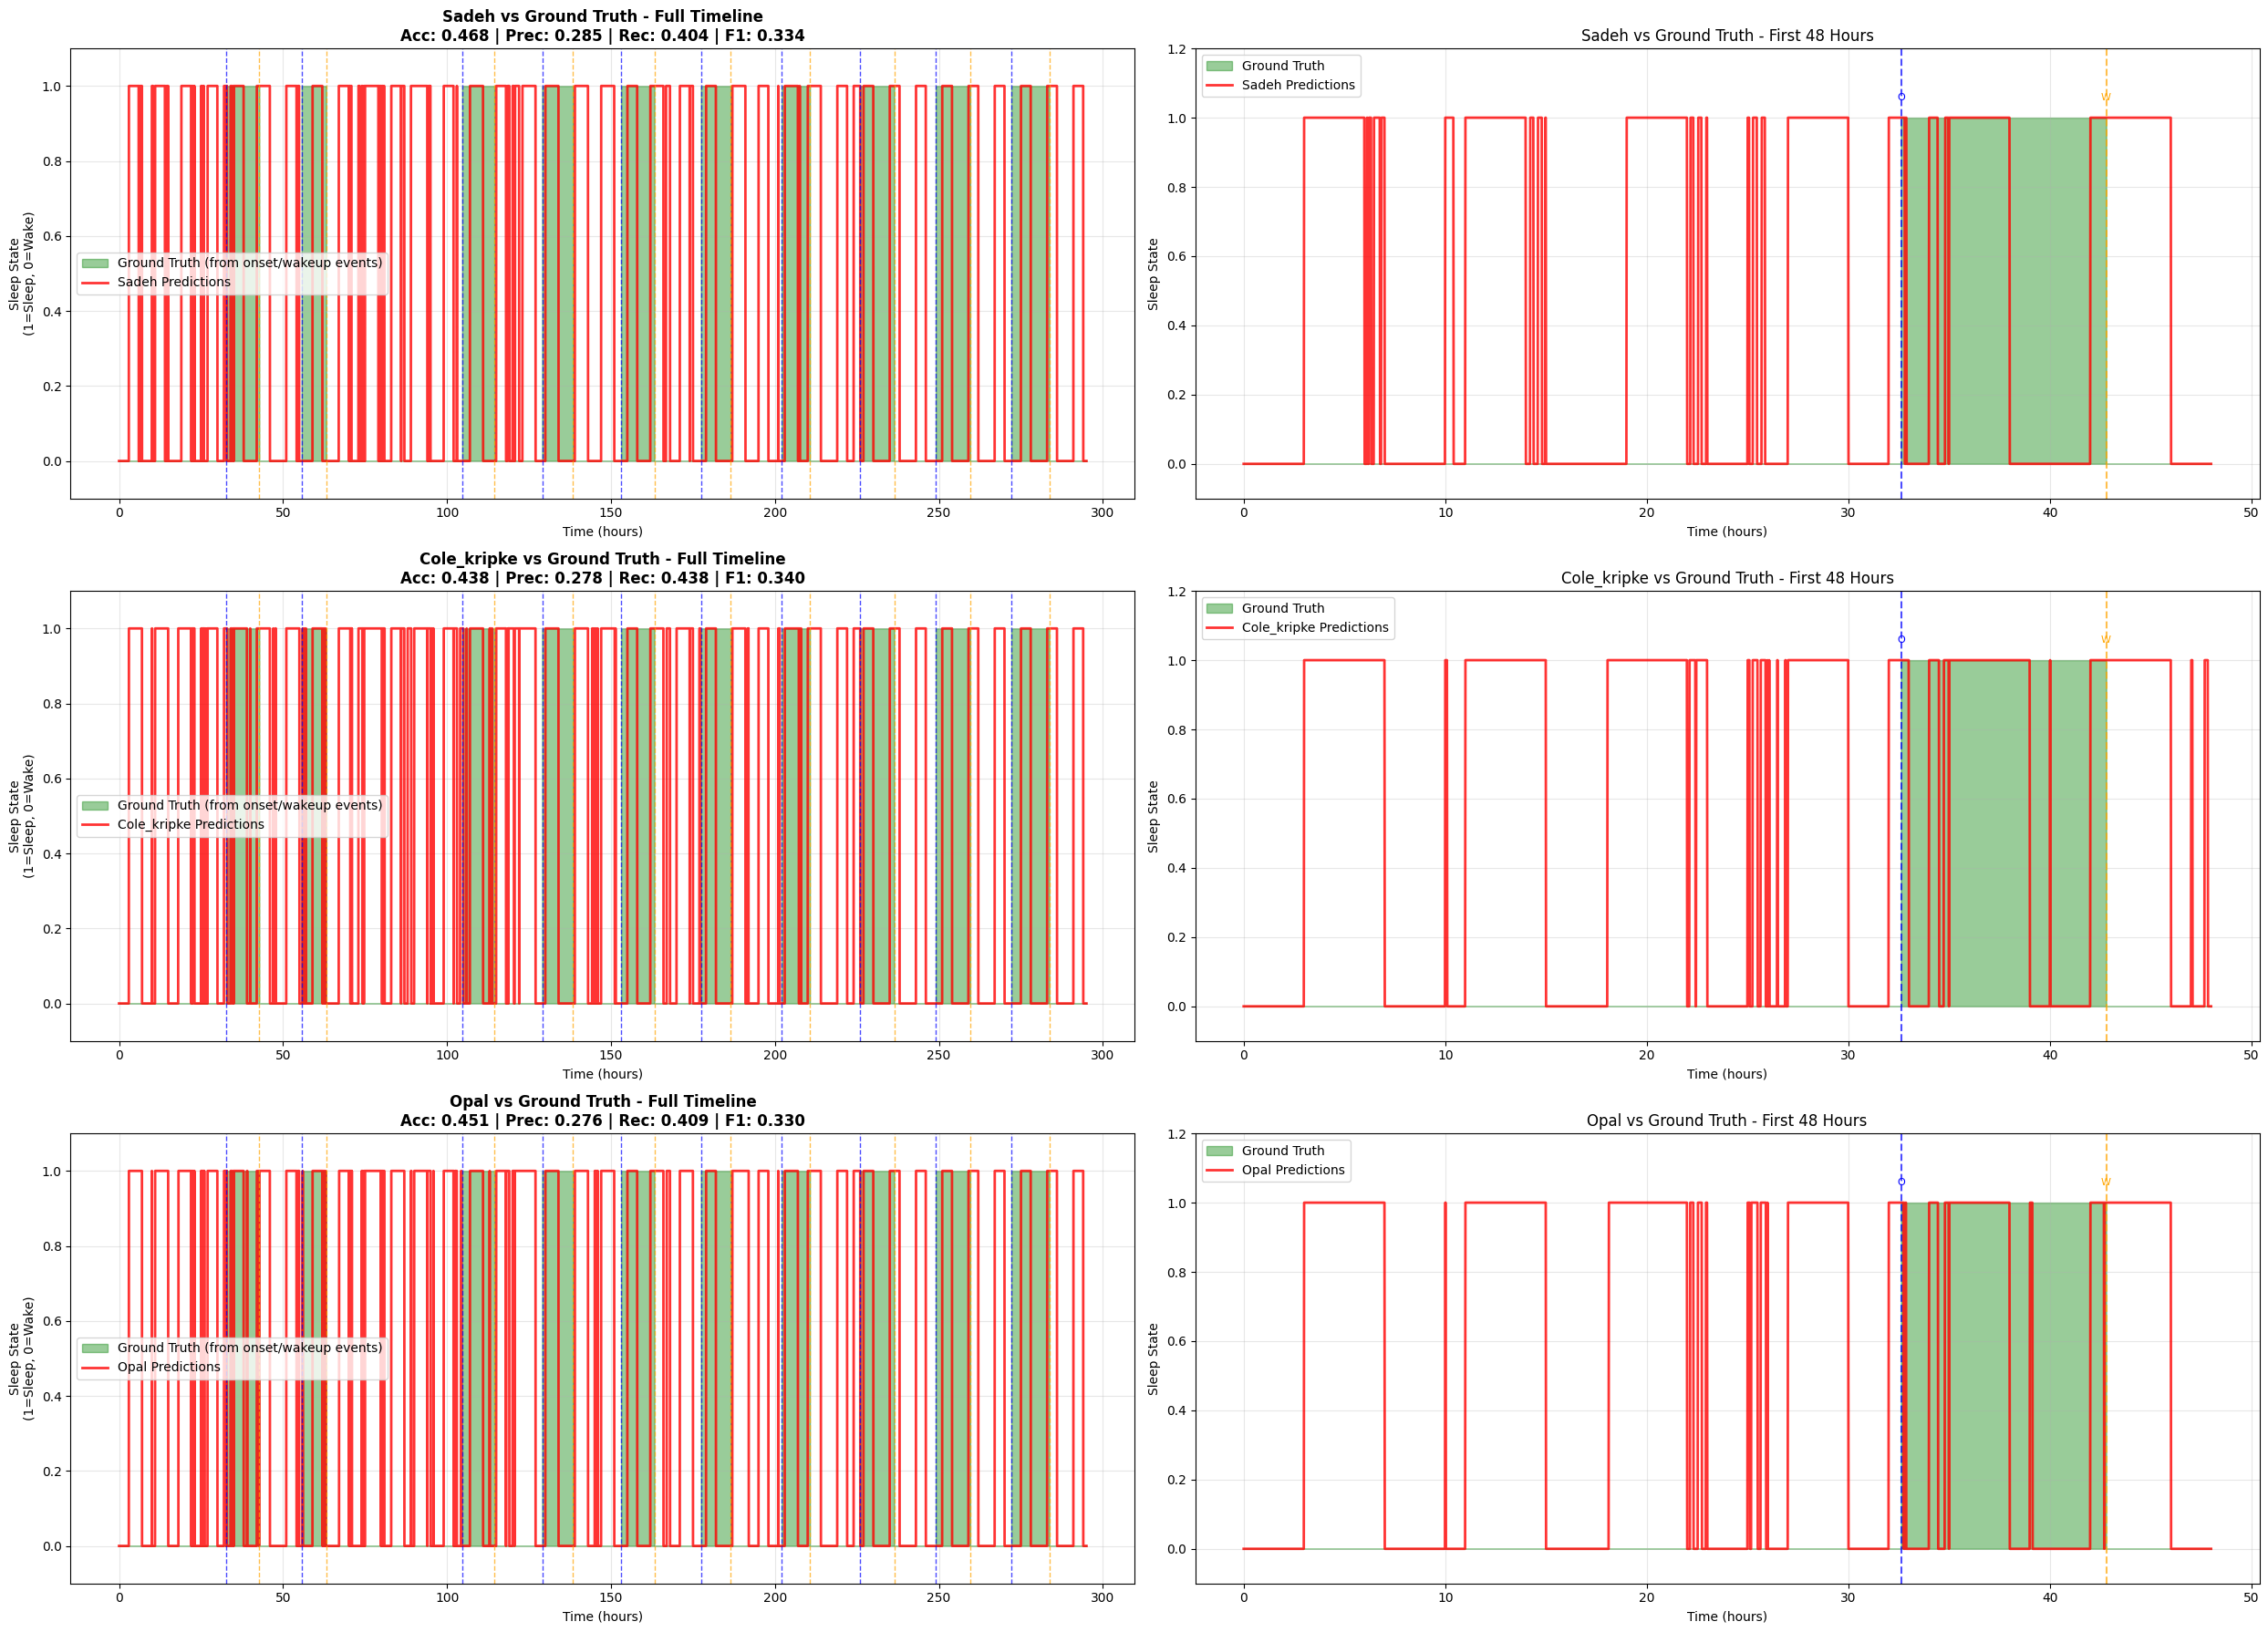


ALGORITHM COMPARISON SUMMARY
Algorithm    Accuracy   Precision   Recall   F1-Score
--------------------------------------------------------------------------------
Sadeh        0.4679     0.2847      0.4043   0.3341  
Cole_kripke  0.4381     0.2776      0.4378   0.3398  
Opal         0.4513     0.2765      0.4092   0.3300  
--------------------------------------------------------------------------------
Best performing algorithm: Cole_kripke (F1-Score: 0.3398)

DETAILED EVENT ANALYSIS FOR COLE_KRIPKE:
Event: onset  | Step: 23484  | Epoch: 1957   | Predicted: 1 | Ground Truth: 1 | Expected: 1 | Match: ✓
Event: wakeup | Step: 30804  | Epoch: 2567   | Predicted: 1 | Ground Truth: 1 | Expected: 0 | Match: ✗
Event: onset  | Step: 40092  | Epoch: 3341   | Predicted: 0 | Ground Truth: 1 | Expected: 1 | Match: ✗
Event: wakeup | Step: 45492  | Epoch: 3791   | Predicted: 0 | Ground Truth: 1 | Expected: 0 | Match: ✓
Event: onset  | Step: 75348  | Epoch: 6279   | Predicted: 1 | Ground Truth: 1 | 

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Filter for the same series we've been analyzing
test_series_filtered = test_df.filter(pl.col('series_id') == first_series_id)

print(f"Test series data for {first_series_id}:")
print(f"Shape: {test_series_filtered.shape}")
print(test_series_filtered.head())

# Get onset and wakeup events from train_events.csv (test_df already loaded)
events_filtered = test_df.filter(pl.col('series_id') == first_series_id)
events_filtered = events_filtered.filter(pl.col('step').is_not_null())

print(f"\nSleep events for {first_series_id}:")
print(f"Shape: {events_filtered.shape}")
print(events_filtered)

# Create binary sleep state based on onset/wakeup events
def create_ground_truth_binary(events_df, total_steps):
    """Create binary sleep state array from onset/wakeup events"""
    binary_sleep = np.zeros(total_steps, dtype=int)
    
    events_sorted = events_df.sort('step')
    events_list = events_sorted.to_dicts()  # Convert to list of dictionaries
    
    for i in range(len(events_list)):
        event = events_list[i]
        step = event['step']
        event_type = event['event']
        
        if event_type == 'onset':
            # Find corresponding wakeup
            next_wakeup = None
            for j in range(i+1, len(events_list)):
                if events_list[j]['event'] == 'wakeup':
                    next_wakeup = events_list[j]['step']
                    break
            
            if next_wakeup is not None:
                # Convert step to epoch index (each epoch = 12 steps)
                onset_epoch = step // 12
                wakeup_epoch = next_wakeup // 12
                
                # Mark sleep period
                if onset_epoch < total_steps and wakeup_epoch < total_steps:
                    binary_sleep[onset_epoch:wakeup_epoch+1] = 1
    
    return binary_sleep

# Create ground truth binary array
ground_truth_binary = create_ground_truth_binary(events_filtered, len(epoch_df))

# Get the minimum length for comparison
min_length = min(len(ground_truth_binary), len(algorithms_comparison['Opal']['predictions']))
ground_truth_subset = ground_truth_binary[:min_length]

# Convert epoch indices to time for better visualization
time_hours_subset = np.arange(len(ground_truth_subset)) / 60

print(f"\nComparison setup:")
print(f"Ground truth length: {len(ground_truth_subset)}")
print(f"Ground truth sleep periods: {np.sum(ground_truth_subset)} epochs")

# Create comprehensive visualization for each algorithm
fig, axes = plt.subplots(len(algorithms_comparison), 2, figsize=(25, 6*len(algorithms_comparison)))

if len(algorithms_comparison) == 1:
    axes = axes.reshape(1, -1)

algorithm_metrics = {}

for idx, (alg_name, alg_data) in enumerate(algorithms_comparison.items()):
    # Get algorithm predictions
    predictions = alg_data['predictions'][:min_length]
    binary_predictions = (predictions > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(ground_truth_subset, binary_predictions)
    precision = precision_score(ground_truth_subset, binary_predictions, zero_division=0)
    recall = recall_score(ground_truth_subset, binary_predictions, zero_division=0)
    f1 = f1_score(ground_truth_subset, binary_predictions, zero_division=0)
    
    algorithm_metrics[alg_name] = {
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1_score': f1
    }
    
    print(f"\n{alg_name.upper()} vs GROUND TRUTH METRICS:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Predicted sleep periods: {np.sum(binary_predictions)} epochs")
    
    # Plot 1: Ground Truth vs Algorithm Predictions (Full timeline)
    ax1 = axes[idx, 0]
    ax1.fill_between(time_hours_subset, 0, ground_truth_subset, alpha=0.4, color='green', 
                     label='Ground Truth (from onset/wakeup events)', step='pre')
    ax1.plot(time_hours_subset, binary_predictions, color='red', linewidth=2, 
             label=f'{alg_name} Predictions', alpha=0.8)
    
    # Mark onset and wakeup events
    events_list = events_filtered.to_dicts()
    for event in events_list:
        if event['step'] is not None:
            event_time = (event['step'] // 12) / 60
            if event_time < time_hours_subset[-1]:
                if event['event'] == 'onset':
                    ax1.axvline(x=event_time, color='blue', linestyle='--', alpha=0.7, linewidth=1)
                else:
                    ax1.axvline(x=event_time, color='orange', linestyle='--', alpha=0.7, linewidth=1)
    
    ax1.set_title(f'{alg_name} vs Ground Truth - Full Timeline\n'
                  f'Acc: {accuracy:.3f} | Prec: {precision:.3f} | Rec: {recall:.3f} | F1: {f1:.3f}', 
                  fontsize=12, fontweight='bold')
    ax1.set_ylabel('Sleep State\n(1=Sleep, 0=Wake)')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylim(-0.1, 1.1)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Detailed view of first 48 hours
    ax2 = axes[idx, 1]
    hours_48 = min(48*60, len(time_hours_subset))  # 48 hours in epochs
    time_48h = time_hours_subset[:hours_48]
    gt_48h = ground_truth_subset[:hours_48]
    pred_48h = binary_predictions[:hours_48]
    
    ax2.fill_between(time_48h, 0, gt_48h, alpha=0.4, color='green', 
                     label='Ground Truth', step='pre')
    ax2.plot(time_48h, pred_48h, color='red', linewidth=2, 
             label=f'{alg_name} Predictions', alpha=0.8)
    
    # Mark events in 48h window
    for event in events_list:
        if event['step'] is not None:
            event_time = (event['step'] // 12) / 60
            if event_time < 48:
                if event['event'] == 'onset':
                    ax2.axvline(x=event_time, color='blue', linestyle='--', alpha=0.7)
                    ax2.text(event_time, 1.05, 'O', fontsize=8, color='blue', ha='center')
                else:
                    ax2.axvline(x=event_time, color='orange', linestyle='--', alpha=0.7)
                    ax2.text(event_time, 1.05, 'W', fontsize=8, color='orange', ha='center')
    
    ax2.set_title(f'{alg_name} vs Ground Truth - First 48 Hours')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Sleep State')
    ax2.set_ylim(-0.1, 1.2)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison table
print("\n" + "="*80)
print("ALGORITHM COMPARISON SUMMARY")
print("="*80)
print(f"{'Algorithm':<12} {'Accuracy':<10} {'Precision':<11} {'Recall':<8} {'F1-Score':<8}")
print("-"*80)

best_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}
best_algorithm = None

for alg_name, metrics in algorithm_metrics.items():
    print(f"{alg_name:<12} {metrics['accuracy']:<10.4f} {metrics['precision']:<11.4f} "
          f"{metrics['recall']:<8.4f} {metrics['f1_score']:<8.4f}")
    
    # Track best performing algorithm
    if metrics['f1_score'] > best_metrics['f1_score']:
        best_metrics = metrics
        best_algorithm = alg_name

print("-"*80)
print(f"Best performing algorithm: {best_algorithm} (F1-Score: {best_metrics['f1_score']:.4f})")

# Detailed event-by-event analysis for best algorithm
print(f"\nDETAILED EVENT ANALYSIS FOR {best_algorithm.upper()}:") # type: ignore
print("="*60)

best_predictions = algorithms_comparison[best_algorithm]['predictions'][:min_length]
best_binary_predictions = (best_predictions > 0.5).astype(int)

events_list = events_filtered.to_dicts()
for event in events_list:
    if event['step'] is not None:
        epoch_idx = event['step'] // 12
        if epoch_idx < len(best_binary_predictions):
            predicted_state = best_binary_predictions[epoch_idx]
            ground_truth_state = ground_truth_subset[epoch_idx]
            
            expected_state = 1 if event['event'] == 'onset' else 0
            
            print(f"Event: {event['event']:<6} | Step: {event['step']:<6} | "
                  f"Epoch: {epoch_idx:<6} | Predicted: {predicted_state} | "
                  f"Ground Truth: {ground_truth_state} | "
                  f"Expected: {expected_state} | "
                  f"Match: {'✓' if predicted_state == expected_state else '✗'}")

In [26]:
notebook_end_time = time.time()
print(f"\nTotal execution time: {(notebook_end_time - notebook_start_time)/60:.2f} minutes")


Total execution time: 0.42 minutes
